In [1]:
# import the necessary packages

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

%load_ext tensorboard
import datetime
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os, cv2
print(tf.__version__)

2.6.0


In [2]:
print(os.getcwd())

/home/user/AI_2/Gender-Classification


## 1.1 Create the Dataset 

In [3]:
# create paths
dataset_path = os.getcwd() + "/dataset"

In [4]:
train_test_dataset = image_dataset_from_directory(dataset_path,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=42)

Found 2307 files belonging to 2 classes.


2021-12-13 21:08:19.611702: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 21:08:19.612615: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
imagePaths = list(paths.list_images(dataset_path))
data       = []
labels     = []# loop over the image paths

for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split("/")[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [6]:
data   = np.array(data, dtype="float64")
labels = np.array(labels)

In [7]:
print('data shape: ', data.shape, '\nlabels shape: ', labels.shape)

data shape:  (2307, 224, 224, 3) 
labels shape:  (2307,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

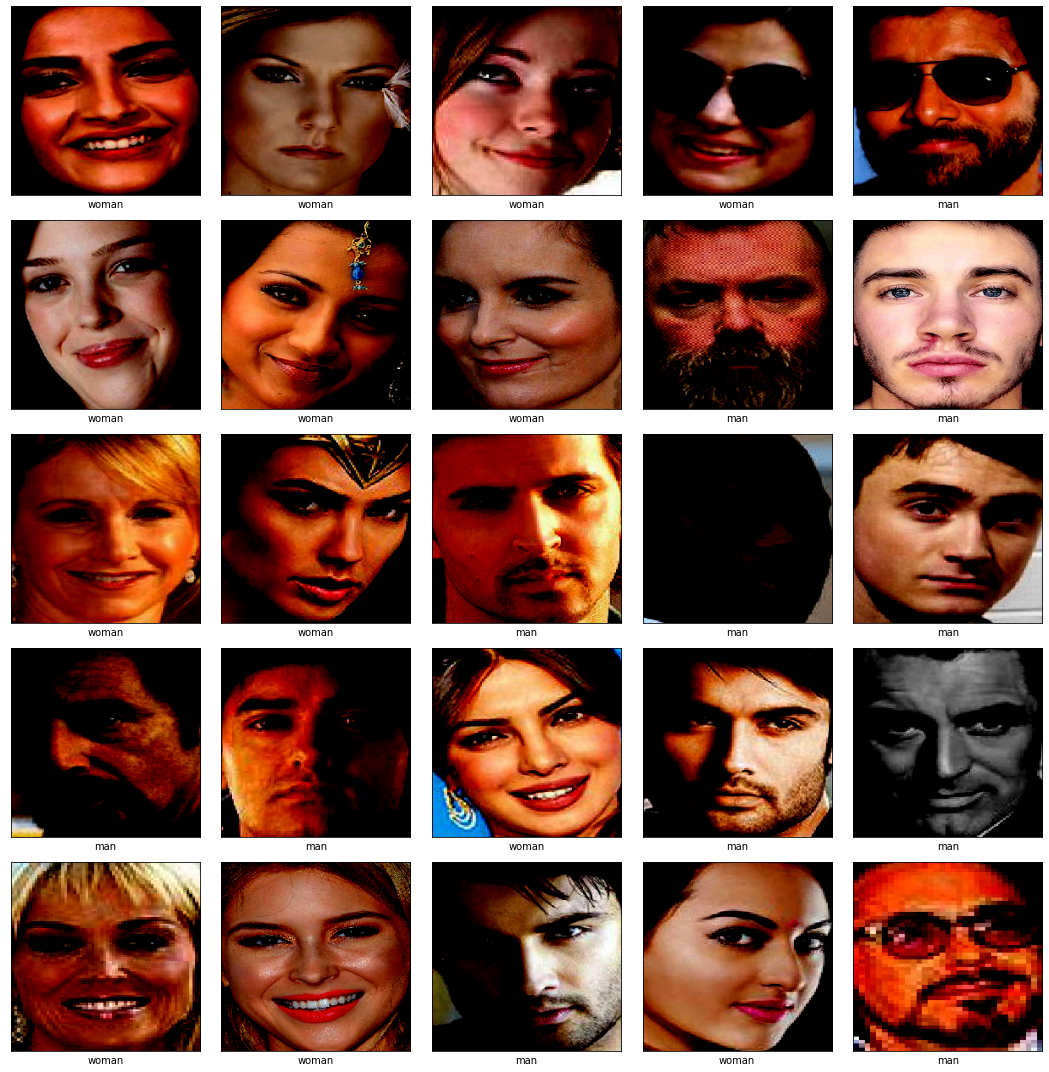

In [8]:
# Check our datset

import random
plt.figure(figsize=(15,15))
nn = 25
for ii in range(0, nn):
    plt.subplot(5,5,ii+1)
    plt.xticks([])
    plt.yticks([])
    randno = random.randint(0, (len(data)-1))
    plt.imshow(data[randno])
    plt.tight_layout()
    plt.xlabel(labels[randno])

In [9]:
# perform one-hot encoding on the labels

lb     = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# 2 - Split it into Training and Validation Sets 

In [10]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# 3 - Construct image generator for data augmentation

In [11]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# 4 - Using MobileNetV2 for Transfer Learning

In [15]:
## Build the mask model

def gender_model(input_shape, optimizer):
    
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False, # <== Important!!!!
                             weights='imagenet') # From imageNet
    
    # construct the head of the model that will be placed on top of the base model
    top_model = base_model.output
    top_model = AveragePooling2D(pool_size=(7, 7))(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1028, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(128, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(2, activation="softmax")(top_model)
    
    model = Model(inputs=base_model.input, outputs = top_model)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    # compile the model

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [16]:
# parameters
IMG_SIZE      = (224, 224, 3)
learning_rate = 1e-4
epochs        = 50
batch_size    = 32

In [17]:
# initialize early stopping callback and optimizer

earlystopping_callback = EarlyStopping(monitor='val_loss', 
                                       min_delta=0, 
                                       patience=10, 
                                       verbose=0, 
                                       mode='auto', 
                                       baseline=None, 
                                       restore_best_weights=True)
optimizer = Adam(learning_rate = learning_rate, decay=learning_rate / epochs)

In [18]:
# initialize model
model = gender_model(IMG_SIZE, optimizer)

In [19]:
# train

history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // batch_size,
    epochs=epochs,
    callbacks=earlystopping_callback)

2021-12-13 21:08:52.401636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
57/57 [==============================] - 52s 871ms/step - loss: 0.7261 - accuracy: 0.6029 - val_loss: 0.5088 - val_accuracy: 0.8312
Epoch 2/50
57/57 [==============================] - 50s 886ms/step - loss: 0.5204 - accuracy: 0.7766 - val_loss: 0.3757 - val_accuracy: 0.8442
Epoch 3/50
57/57 [==============================] - 48s 841ms/step - loss: 0.4078 - accuracy: 0.8395 - val_loss: 0.3516 - val_accuracy: 0.8312
Epoch 4/50
57/57 [==============================] - 50s 868ms/step - loss: 0.3630 - accuracy: 0.8571 - val_loss: 0.2955 - val_accuracy: 0.8658
Epoch 5/50
57/57 [==============================] - 47s 827ms/step - loss: 0.3440 - accuracy: 0.8682 - val_loss: 0.2830 - val_accuracy: 0.8788
Epoch 6/50
57/57 [==============================] - 50s 883ms/step - loss: 0.3257 - accuracy: 0.8731 - val_loss: 0.3089 - val_accuracy: 0.8485
Epoch 7/50
57/57 [==============================] - 47s 831ms/step - loss: 0.2994 - accuracy: 0.8753 - val_loss: 0.2417 - val_accuracy: 0.8961

# 5 - Model Evaluation and Prediction

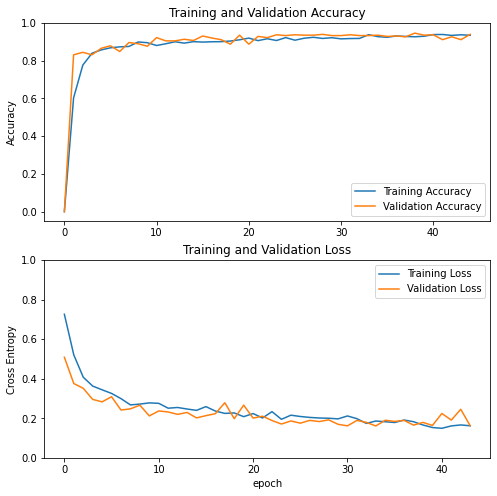

<Figure size 432x288 with 0 Axes>

In [43]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
model.evaluate(X_train, y_train)

58/58 [==============================] - 29s 478ms/step - loss: 0.1443 - accuracy: 0.9409


[0.1443248838186264, 0.940921425819397]

In [22]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 6s 393ms/step - loss: 0.1609 - accuracy: 0.9351


[0.16093455255031586, 0.9350649118423462]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


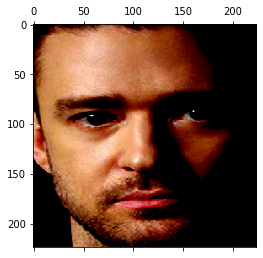

In [23]:
plt.matshow(X_test[59])

In [24]:
y_test[59]

array([1., 0.], dtype=float32)

In [25]:
# make predictions on the testing set

predIdxs = model.predict(X_test, batch_size=batch_size)

In [26]:
predIdxs.shape

(462, 2)

In [44]:
class_lables = ["Man", "Woman"]

In [28]:
test_y = np.array([np.argmax(ii) for ii in y_test])
test_y

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,

In [29]:
y_predict_labels = np.array([np.argmax(ii) for ii in predIdxs])
y_predict_labels

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,

Text(69.0, 0.5, 'Truth')

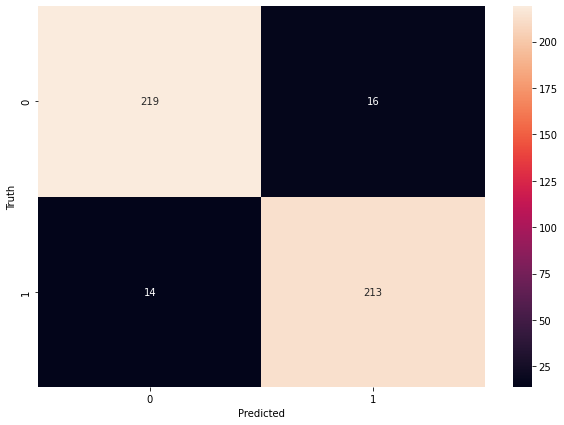

In [34]:
cm = tf.math.confusion_matrix(labels = test_y, predictions = y_predict_labels)
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [35]:
# classification report

print(classification_report(test_y, y_predict_labels))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       235
           1       0.93      0.94      0.93       227

    accuracy                           0.94       462
   macro avg       0.94      0.94      0.94       462
weighted avg       0.94      0.94      0.94       462



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

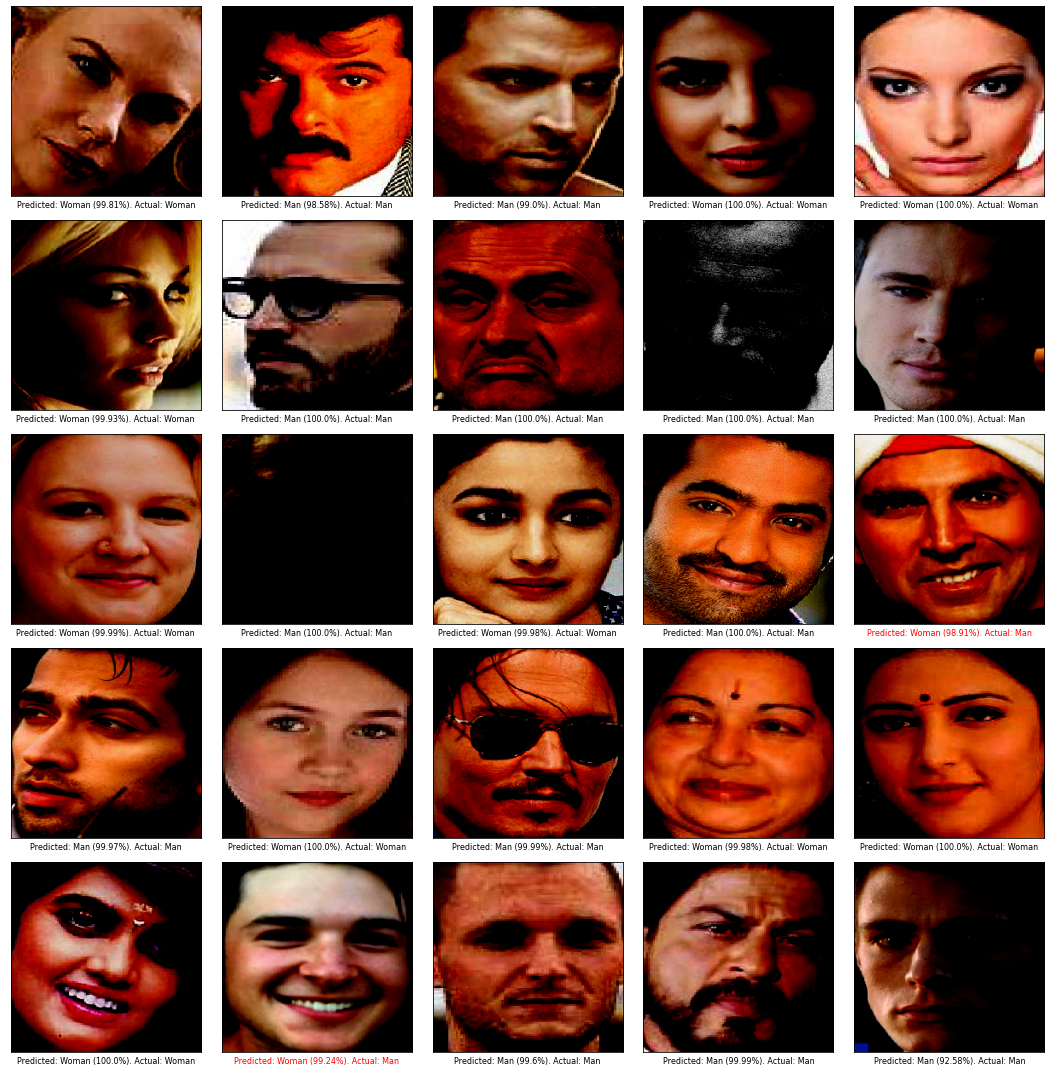

In [45]:
# Plot random sample to check predictions

plt.figure(figsize=(15,15))
nn = 25
for ii in range(0, nn):
    plt.subplot(5,5,ii+1)
    plt.xticks([])
    plt.yticks([])
    randno = random.randint(0, (len(X_test)-1))
    plt.imshow(X_test[randno])
    plt.tight_layout()
    if y_predict_labels[randno] == test_y[randno]:
        color = 'black'
    else:
        color = 'red'
    plt.xlabel('Predicted: ' + str(class_lables[y_predict_labels[randno]]) + ' (' +
              str(round(100*np.max(predIdxs[randno]), 2)) + "%). " +
               "Actual: " + str(class_lables[test_y[randno]]), color = color, fontsize = 8)

In [37]:
model_path   = os.getcwd() + "/model/gender_model"
dataset_path

'/home/user/AI_2/Gender-Classification/dataset'

In [38]:
# save the model as .h5 files

model.save(model_path+".h5")  #h5 format

/home/user/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
model.save(model_path)

2021-12-13 22:10:37.547158: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/user/AI_2/Gender-Classification/model/gender_model/assets


/home/user/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [40]:
## Loading the model from the saved location
loaded_model = tf.keras.models.load_model(os.getcwd() + "/model/gender_model")

## check architecture
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________